In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = torchvision.datasets.SVHN(root='data/', download=True, transform=ToTensor())

'''
Note: The SVHN dataset assigns the label `10` to the digit `0`. However, in this Dataset,
we assign the label `0` to the digit `0` to be compatible with PyTorch loss functions which
xpect the class labels to be in the range `[0, C-1]`
'''

'''
data_loader = torch.utils.data.DataLoader(svhn_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)
'''

  0%|          | 0/182040794 [00:00<?, ?it/s]

'\ndata_loader = torch.utils.data.DataLoader(svhn_data,\n                                          batch_size=4,\n                                          shuffle=True,\n                                          num_workers=args.nThreads)\n'

In [3]:
len(dataset.labels)

73257

In [4]:
# use the random_split helper function to set aside 12000 images for our validation set from the dataset
val_size = 12000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(61257, 12000)

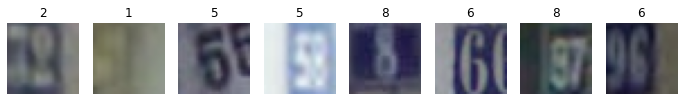

In [5]:
# img, label = train_ds[5]

figure = plt.figure(figsize=(12, 12))
cols, rows = 8, 1
for i in range(1, cols * rows + 1):
    img, label = train_ds[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute((1, 2, 0)))
plt.show()

In [6]:
# check labels distribution

import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_labels = []
for img, label in train_ds:
  train_labels.append(label)

val_labels = []
for img, label in val_ds:
  val_labels.append(label)

train_lables_c = sorted(collections.Counter(train_labels).items())
train_lables_df = pd.DataFrame(train_lables_c, columns=['lable', 'count'])

val_lables_c = sorted(collections.Counter(val_labels).items())
val_lables_df = pd.DataFrame(val_lables_c, columns=['lable', 'count'])


In [7]:
all_labels = train_labels+val_labels
all_labels = sorted(collections.Counter(all_labels).items())
all_labels_df = pd.DataFrame(all_labels, columns=['lable', 'count'])
all_labels_df 

,lable,count
0,0,4948
1,1,13861
2,2,10585
3,3,8497
4,4,7458
5,5,6882
6,6,5727
7,7,5595
8,8,5045
9,9,4659


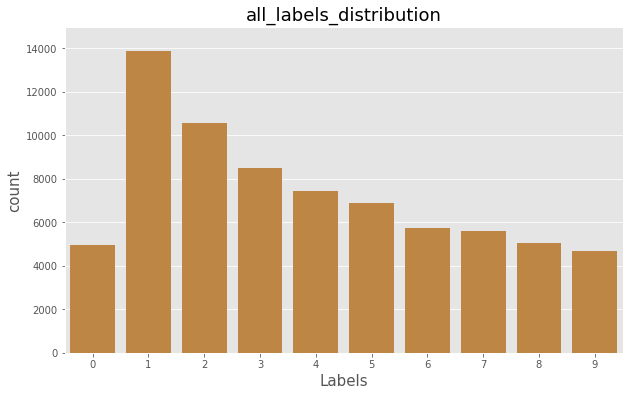

In [8]:
# plot


plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))

f1 = sns.barplot(x='lable', y='count', data = all_labels_df, color="#D18731")
f1.set_title('all_labels_distribution', size=18)
f1.set_xlabel('Labels', size=15)
f1.set_ylabel('count', fontsize=15)
f1.set_ylim([0, 15000])


#display barplot
plt.show()

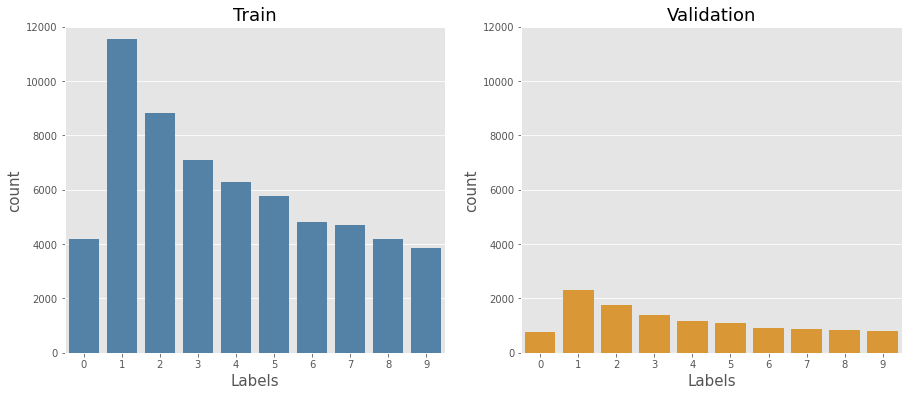

In [9]:
# plot

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

f1 = sns.barplot(x='lable', y='count', data = train_lables_df, color='steelblue', ax=axes[0])
f1.set_title('Train', size=18)
f1.set_xlabel('Labels', size=15)
f1.set_ylabel('count', fontsize=15)
f1.set_ylim([0, 12000])

f2 = sns.barplot(x='lable', y='count', data = val_lables_df, color='#F49D1A', ax=axes[1])
f2.set_title('Validation', size=18)
f2.set_xlabel('Labels', size=15)
f2.set_ylabel('count', fontsize=15)
f2.set_ylim([0, 12000])

#display barplot
plt.show()

In [10]:
device = torch.device('cuda:0')  # or whatever device/cpu you like
device

device(type='cuda', index=0)

In [11]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([5, 2, 8, 5, 6, 1, 6, 4, 2, 2, 8, 0, 1, 8, 1, 6, 6, 6, 4, 8, 3, 2, 1, 2,
        1, 2, 9, 3, 1, 4, 5, 4, 7, 3, 7, 3, 2, 1, 4, 2, 6, 4, 2, 1, 4, 9, 1, 1,
        2, 0, 6, 2, 8, 3, 8, 5, 1, 4, 8, 4, 3, 7, 4, 2])
images.shape: torch.Size([64, 3, 32, 32])


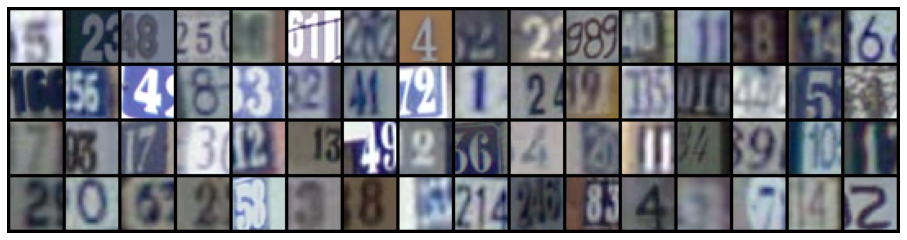

In [12]:
for images, labels in train_loader:
  
    print(labels)
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# images.to(device).get_device()
# labels.to(device).get_device()

### ANN

In [13]:
class SvhnModel(nn.Module):
    """Feedfoward neural network with 6 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, 64)
        self.linear6 = nn.Linear(64, 32)
        # output layer
        self.linear7 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear7(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        # acc = accuracy_score(out, labels)           # Calculate accuracy
      
        pred = out.data.max(1, keepdim=True)[1]
        correct = 0 
        correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        acc = correct / len(labels)

        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [14]:
input_size = 3072
num_classes = 10

model = SvhnModel(input_size, out_size=num_classes)

for t in model.parameters():
   print(t.shape)

for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([1024, 3072])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])
Loss: 2.3118338584899902
outputs.shape :  torch.Size([64, 10])
Sample outputs :
 tensor([[ 0.1459,  0.0222, -0.1076,  0.0207, -0.1085,  0.0314, -0.1111, -0.0143,
         -0.1249,  0.0301],
        [ 0.1468,  0.0217, -0.1076,  0.0203, -0.1088,  0.0323, -0.1110, -0.0146,
         -0.1254,  0.0307]])


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([2, 1, 5, 3, 7, 3, 3, 9, 9, 9, 0, 1, 8, 2, 5, 9, 1, 7, 2, 2, 2, 4, 8, 2,
        2, 0, 7, 0, 1, 5, 7, 3, 5, 5, 8, 2, 6, 5, 5, 1, 1, 0, 8, 1, 5, 3, 1, 6,
        7, 0, 0, 0, 7, 2, 1, 5, 4, 4, 5, 7, 3, 8, 9, 9, 8, 2, 4, 0, 1, 6, 3, 3,
        2, 2, 3, 1, 1, 3, 1, 6, 8, 2, 4, 6, 2, 0, 7, 9, 3, 6, 1, 6, 1, 1, 0, 1,
        1, 6, 1, 1, 1, 6, 1, 2, 4, 0, 4, 3, 4, 1, 8, 0, 8, 9, 1, 1, 8, 2, 3, 1,
        2, 1, 8, 1, 6, 0, 1, 2])


In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = SvhnModel(input_size, out_size=num_classes)

history = [evaluate(model, val_loader)]
history += fit(1, 1e-2, model, train_loader, val_loader)
history = pd.DataFrame(history)

Epoch [0], val_loss: 2.2359, val_acc: 0.1926
